# Identifying patterns in protein adaptation to temperature.

**Acknowledgement**: A huge thanks to [Antonin Affholder](https://www.ens.psl.eu/actualites/antonin-affholder) for the dataset and global layout of this mini-project.

![antonin](https://www.ens.psl.eu/sites/default/files/2020-01/antonin-affholder-800-pix.jpg)


## Problem

<!-- Proteins of species living in high or low temperature have specific properties. -->

Proteins from bacteria and archaea have often been used to elucidate patterns in protein adaptation across wide temperature ranges. To identify these patterns, researchers compared sequences of families of homologous high and low-temperature proteins. This approach allows to extract recurring amino acid replacement trends potentially important for thermal adaptation (e.g. more charged and hydrophobic amino acids).

From a set of protein sequences of mesophilic* and hyperthermophilic** archaea, your mission, should you choose to accept it, is to code a script that would detect preferential amino acid replacement in hyperthermophilic species, that would indicate adaptation to high temperature.
- `*` mesophilic organism = organism that grows in moderate temperatures (between 20°C and 45°C)
- `**`hyperthermophilic organism = organism that thrives in extremely hot environments (above 60°C)

Here, we are interested in comparing hyperthermophiles with mesophiles.

### Details

The dataset you will use (`Ftr_A.aln`) consists in an alignement of the set of protein sequences (an enzyme involved in methanogenesis) of mesophilic and hyperthermophilic archaea species, aligned with the software MAFFT, it follows the same standards as the fasta format.
The `metadata.csv` file is a table containing the information on the dataset and most importantly associates sequences ID with organism type (hyperthermophile, thermophile or mesophile).

The number of substitutions from mesophilic sequences to hyperthermophilic sequences will be stored in a matrix. This will be a 20x20 matrix (as there are 20 amino acids). Element M[i,j] will be the number of substitutions from amino-acid i in the mesophilic sequences to amino-acid j in the hyperthermophile sequences.

The substitution ratios are then computed by dividing the substitution matrix M by its transpose.

<!-- Is there a preferential amino acid replacement in hyperthermophilic species? Can you identify groups of amino acids (charged, polar, hydrophobic) that are preferentially replaced? -->

### Some tips

To do so, you will need to:

- Find a way to read data
- Classify the two types of sequences (mesophilic and hyperthermophilic)
- Compute and store in a matrix the number of amino acids substitutions between the two sets of sequences (mesophilic and hyperthermophilic)
- Compute the substitution ratios from mesophilic to hyperthermophilic sequences
- Visually represent the substitution matrix as a heatmap
- Conclude on a potential preferential amino acid replacement 


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## Step 1 - File reading
### Metadata file

In [14]:
# TODO: Load metadata.csv as a dataframe
metadata = pd.read_csv("metadata.csv")
metadata.head(5)

,ID,Organism,Superkingdom,Phylum,class,Order,Family,Tg (K),Type
0,190192,Methanopyrus kandleri AV19,Archaea,Euryarchaeota,Methanopyri,Methanopyrales,Methanopyraceae,371.0,HT
1,880724,Methanotorris igneus Kol 5,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanocaldococcaceae,361.0,HT
2,243232,Methanocaldococcus jannaschii DSM 2661,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanocaldococcaceae,358.0,HT
3,573063,Methanocaldococcus infernus ME,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanocaldococcaceae,358.0,HT
4,573064,Methanocaldococcus fervens AG86,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanocaldococcaceae,358.0,HT


In [15]:
np.unique(metadata["Type"])

array(['HT', 'M', 'T'], dtype=object)

In [20]:
# TODO: Find the organism IDs of the mesophilic and hyperthermophilic archaea

# hyperthermophilic
ht_id = metadata["ID"][metadata["Type"]=="HT"].values
# mesophilic
m_id =  metadata["ID"][metadata["Type"]=="M"].values

print(ht_id)
print(m_id)
# We expect:
# [ 190192  880724  243232  573063  573064  523846  579137 1069083]
# [ 647171  187420  523845   79929  647113  523844 1041930  882090  419665
#   351160 1715806  323259    2162]

[ 190192  880724  243232  573063  573064  523846  579137 1069083]
[  28892  937775  230361  456320 1434123  420247  426368 1201294  410358
  386456  192952  456442  304371  294671  269797  634498  593750  877455
  521011  406327  408577 1036677 1434111  368407]


### Aligned sequences
#### Reading of a row of data

In [24]:
def read_aln_row(row):
    """Parse a row of an aln file and return its content.
    
    If the row does not contain any data, None is returned.
    
    Parameters
    ----------
    row: str
        A row of an aln file.
        
    Returns
    -------
    parsed_row: dict or None
        A dictionary containing the parsed data.
        The dictionary has format:
        
            {"organism_id": organism_id,
             "sequence": sequence,
              "end_position": end_position}
              
        Where organism_id, sequence and end_position correspond to:
        
        organism_id: int
            The organism ID.

        sequence: str
            The protein sequence stored on the row.

        end_position: int
            The position of the last amino-acid of the row.
    """
    # Parse row using a regular expression
    pattern = "(?P<organism_id>\d+)\s+(?P<sequence>\w+)\s+(?P<end_position>\d+)\n"
    
    my_match = re.search(pattern, row)
    if my_match:  # Parse the row if it matches the pattern
        # Use groupdict to convert the match to a dict
        parsed_row = my_match.groupdict()

        # Convert organism_id and end_position to integers
        parsed_row["organism_id"] = int(parsed_row["organism_id"])
        parsed_row["end_position"] = int(parsed_row["end_position"])

        return parsed_row
    # Return None if no match was found
    else:
        return None

In [11]:
# Example row
row = "190192    MEINGVEIEDTFAEAFEAKMARVLITAASHKWAMIAVKEATGFGTSVIMCPAEAGIDCYVPPEETPDGRP 70\n"
read_aln_row(row)
# We expect:
# {'organism_id': 190192,
#  'sequence': 'MEINGVEIEDTFAEAFEAKMARVLITAASHKWAMIAVKEATGFGTSVIMCPAEAGIDCYVPPEETPDGRP',
#  'end_position': 70}
# WARNING: organism_id and end_position should be integers

{'organism_id': 190192,
 'sequence': 'MEINGVEIEDTFAEAFEAKMARVLITAASHKWAMIAVKEATGFGTSVIMCPAEAGIDCYVPPEETPDGRP',
 'end_position': 70}

#### Parsing of the full file

In [12]:
def read_text_file(path):
    """Return the rows of a text file as elements of a list
    
    Parameters
    ----------
    path: str
        The path to the text file to read
    
    Returns
    -------
    list of str
        A list containing the text file's rows.
    """
    with open(path, "r") as f:
        row_all = f.readlines()
    return row_all

In [13]:
# Test it on the data
data_path = "Ftr_A.aln"
# Print the first four lines of the file
read_text_file(data_path)[:4]

# We expect:
# ['CLUSTAL W 2.0 multiple sequence alignment\n',
#  '\n',
#  '190192    MEINGVEIEDTFAEAFEAKMARVLITAASHKWAMIAVKEATGFGTSVIMCPAEAGIDCYVPPEETPDGRP 70\n',
#  '243232    MEINGVYIEDTFAEAFPIWVSRVLITAATKKWAKIAATEATGFGCSVIMCPAEAGIEKYVPPSKTPDGRP 70\n']

['CLUSTAL W 2.0 multiple sequence alignment\n',
 '\n',
 '190192    MEINGVEIEDTFAEAFEAKMARVLITAASHKWAMIAVKEATGFGTSVIMCPAEAGIDCYVPPEETPDGRP 70\n',
 '243232    MEINGVYIEDTFAEAFPIWVSRVLITAATKKWAKIAATEATGFGCSVIMCPAEAGIEKYVPPSKTPDGRP 70\n']

In [34]:
def load_aln_data(path):
    """Load an aln file as a pandas dataframe

    Parameters
    ----------
    path: str
        The path to the data file.

    Returns
    -------
    df: pd.DataFrame
        The aligned sequences stored in a dataframe.
        Each row correspond to a position in the sequence,
        each column to an organism ID.
    """


    # Open the file whose path is given as input and read its content
    row_all = read_text_file(path)

    # Parse each row and store those containing data in a list
    parsed_row_all = []
    for row in row_all:
        parsed_row = read_aln_row(row)
        if parsed_row is not None:
            parsed_row_all.append(parsed_row)

    # Find the maximum value of end position and all organism IDs
    # TODO
    end_position_max = -1
    organism_id_all = []
    for parsed_row in parsed_row_all:
        # update end_position_max if end_position is bigger
        if parsed_row["end_position"] > end_position_max:
            end_position_max = parsed_row["end_position"]

        # append the organism id if it is not already in the list
        if parsed_row["organism_id"] not in organism_id_all:
            organism_id_all.append(parsed_row["organism_id"])

    # Preallocate the output dataframe
    df = pd.DataFrame(index=np.arange(1, end_position_max + 1),
                      columns=organism_id_all, dtype=str)

    # Store the data from each parsed row in df
    for parsed_row in parsed_row_all:
        # Convert my sequence to a list of amino acids
        sequence_as_list = []
        for e in parsed_row["sequence"]:
            sequence_as_list.append(e)

        # Find the start and end index of the sequence
        end_idx = parsed_row["end_position"]
        start_idx = end_idx - len(parsed_row["sequence"]) + 1

        # Allocate the value in df
        df.loc[start_idx:end_idx, parsed_row["organism_id"]] = sequence_as_list

    return df

In [35]:
data_path = "Ftr_A.aln"
data = load_aln_data(data_path)
data.head(5)

# We expect something similar to:
#    190192  243232  523846  573063  573064  579137  880724  1069083   2162  ...   
# 1       M       M       M       M       M       M       M       M       M   
# 2       E       E       K       E       E       E       E       E       E   
# 3       I       I       V       I       I       I       I       I       I   
# 4       N       N       N       N       N       N       N       N       N   
# 5       G       G       G       G       G       G       G       G       G   

,190192,243232,523846,573063,573064,579137,880724,1069083,2162,79929,...,192952,410358,1201294,426368,420247,456320,1434123,230361,28892,937775
1,M,M,M,M,M,M,M,M,M,M,...,M,M,M,M,M,M,M,M,M,M
2,E,E,K,E,E,E,E,E,E,E,...,E,E,E,E,E,E,E,E,E,E
3,I,I,V,I,I,I,I,I,I,I,...,I,F,L,L,I,L,I,I,Y,L
4,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
5,G,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,G


## Step 2 - Number of substitutions
We will loop over each pair of mesophilic and hyperthermophilic organism and each position and store the comparison between each resulting pair of aminoacid in a pandas dataframe. 

In [44]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
               'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

substitution_count = pd.DataFrame(np.zeros((len(amino_acids), len(amino_acids)), dtype=int),
                                  index=amino_acids, columns=amino_acids)


# TODO: for each mesophilic archae, loop over all hyperthermophilic organisms
# and over each position in the sequence and increment the count of substitutions
# E.G. substitution_count["A"]["L"] is how many time an Alanine in the sequence of a
# mesophilic archae was replaced by a leucine in the protein sequence of a hyperthermophilic
# archae

for meso in m_id:
    for hyper in ht_id:
        if meso in list(data) and hyper in list(data):
            for position in data.index:
                aminoacid_meso = data.loc[position, meso]
                aminoacid_hyper = data.loc[position, hyper]
                substitution_count.loc[aminoacid_meso, aminoacid_hyper] += 1

In [45]:
substitution_count

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,4249,131,59,304,19,335,49,171,233,8,31,19,77,80,58,172,131,266,0,32
C,64,705,20,18,8,24,7,20,59,18,4,3,0,0,0,29,99,58,0,8
D,37,0,1104,472,0,90,2,0,89,0,1,170,30,6,12,85,46,0,0,16
E,60,0,348,2638,0,74,217,15,414,70,23,70,0,158,23,146,24,39,0,89
F,0,7,1,12,2059,1,5,84,60,42,72,17,35,4,5,0,0,15,2,387
G,292,11,94,74,0,4267,10,0,53,0,105,26,92,33,6,55,56,30,0,36
H,3,0,0,27,2,1,113,0,77,0,0,10,0,1,54,16,0,0,6,50
I,39,0,6,11,86,38,0,3030,58,307,55,5,1,22,8,0,50,568,0,36
K,42,3,120,372,15,55,40,60,2272,56,14,95,12,92,158,74,53,129,50,16
L,12,0,18,9,77,21,0,238,66,1613,147,4,1,51,0,6,4,168,60,17


### Step 4 - Substitution ratio
Compute the substitution ratios by dividing the substitution matrix by its transpose and plot the result.

In [46]:
# TODO: Compute the substitution ratios
substitution_ratios = substitution_count / substitution_count.T

In [47]:
substitution_ratios
# We expect something similar to:
#           A         C         D         E         F         G          H ...
# A  1.000000  4.050000  0.363636  5.125000  0.000000  1.118110        inf   
# C  0.246914  1.000000       NaN       NaN       NaN  0.590909        inf   
# D  2.750000       NaN  1.000000  1.314607       NaN  1.294118   0.000000   
# E  0.195122       NaN  0.760684  1.000000  0.000000  2.421053   3.310345   
# ...

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,1.000000,2.046875,1.594595,5.066667,inf,1.147260,16.333333,4.384615,5.547619,0.666667,0.310000,19.000000,7.700000,20.000000,9.666667,0.830918,1.082645,1.494382,NaN,10.666667
C,0.488550,1.000000,inf,inf,1.142857,2.181818,inf,inf,19.666667,inf,inf,inf,NaN,0.000000,0.000000,14.500000,1.087912,2.148148,NaN,inf
D,0.627119,0.000000,1.000000,1.356322,0.000000,0.957447,inf,0.000000,0.741667,0.000000,0.111111,0.955056,0.612245,0.400000,1.000000,2.931034,1.642857,0.000000,NaN,inf
E,0.197368,0.000000,0.737288,1.000000,0.000000,1.000000,8.037037,1.363636,1.112903,7.777778,4.600000,2.000000,0.000000,0.934911,1.437500,2.433333,0.315789,0.886364,NaN,5.235294
F,0.000000,0.875000,inf,inf,1.000000,inf,2.500000,0.976744,4.000000,0.545455,3.428571,2.428571,inf,0.571429,inf,NaN,NaN,0.140187,inf,1.032000
G,0.871642,0.458333,1.044444,1.000000,0.000000,1.000000,10.000000,0.000000,0.963636,0.000000,4.038462,0.604651,46.000000,8.250000,3.000000,0.982143,1.696970,2.727273,NaN,inf
H,0.061224,0.000000,0.000000,0.124424,0.400000,0.100000,1.000000,NaN,1.925000,NaN,0.000000,0.277778,NaN,0.022727,inf,inf,0.000000,0.000000,0.666667,8.333333
I,0.228070,0.000000,inf,0.733333,1.023810,inf,NaN,1.000000,0.966667,1.289916,0.679012,0.416667,0.111111,1.692308,1.000000,0.000000,0.757576,0.810271,0.000000,0.620690
K,0.180258,0.050847,1.348315,0.898551,0.250000,1.037736,0.519481,1.034483,1.000000,0.848485,0.636364,0.730769,0.077419,0.617450,1.006369,0.342593,0.350993,1.240385,2.272727,0.141593
L,1.500000,0.000000,inf,0.128571,1.833333,inf,NaN,0.775244,1.178571,1.000000,2.194030,0.666667,0.125000,5.100000,0.000000,1.000000,0.173913,0.774194,2.307692,inf


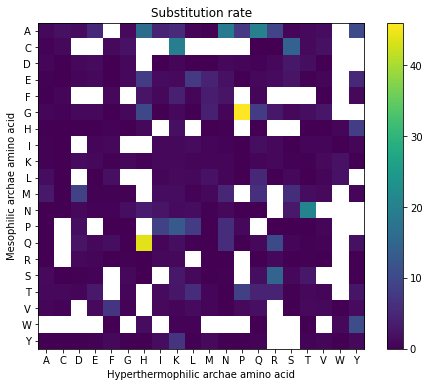

In [48]:
# TODO: Plot the output
plt.figure(figsize=(8, 6))
plt.imshow(substitution_ratios)
# Add the Amino Acids 1 letter code on the sides
plt.yticks(np.arange(len(substitution_ratios.index)), substitution_ratios.index)
plt.xticks(np.arange(len(substitution_ratios.index)), substitution_ratios.columns)

plt.ylabel("Mesophilic archae amino acid")
plt.xlabel("Hyperthermophilic archae amino acid")
plt.title("Substitution rate")
plt.colorbar()
plt.show()